In [109]:
%matplotlib inline

In [110]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

In [161]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [195]:
latest_niv = get_latest_file_glob('data/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-07-02,1,0,0,0,0,שלילי,No,זכר,Other
1,2020-07-02,0,0,0,0,0,שלילי,No,זכר,Other
2,2020-07-02,1,0,0,0,0,שלילי,No,נקבה,Abroad
3,2020-07-02,0,0,0,0,0,שלילי,No,זכר,Other
4,2020-07-02,0,0,0,0,0,שלילי,No,נקבה,Other


In [196]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [197]:
latest_bdi = get_latest_file_glob('data/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [198]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [199]:
bdi.head()

,test_date,result_date,corona_result,lab_id,is_first_Test,orig_test_date
0,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
1,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
2,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
3,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
4,2020-03-11,2020-03-11,שלילי,2,Yes,NaT


In [200]:
bdi.shape

(1043340, 6)

In [201]:
bdi.corona_result.value_counts()

שלילי               975648
חיובי                50356
לא בוצע/פסול 999     12049
חיובי גבולי           4282
בעבודה                 609
לא ודאי                396
Name: corona_result, dtype: int64

In [202]:
niv.corona_result.value_counts()

שלילי    734839
חיובי     25302
אחר        9224
Name: corona_result, dtype: int64

In [203]:
niv.test_indication.value_counts()

Other                     724701
Abroad                     27472
Contact with confirmed     17192
Name: test_indication, dtype: int64

In [204]:
niv.age_60_and_above.value_counts()

No     253209
Yes     44362
Name: age_60_and_above, dtype: int64

In [205]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [206]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [207]:
bdi['corona_result'] = bdi.corona_result.map(result_map)

In [208]:
rec = pd.read_csv(get_latest_file_glob('data/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,43,9,0-19,NaN,Other
1,36,9,20-29,NaN,Contact with confirmed
2,41,9,20-29,NaN,Contact with confirmed
3,34,9,0-19,NaN,Other
4,78,9,60+,NaN,Contact with confirmed


In [209]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

,total_tests_count,size,min,max,mean,median,test_sum
0,2,7,1,15,6.857143,6,14
1,3,7650,2,96,16.003922,16,22950
2,4,3294,2,98,20.525501,20,13176
3,5,2292,4,76,24.033595,24,11460
4,6,1412,6,93,27.226629,27,8472
5,7,895,8,63,30.231285,30,6265
6,8,523,3,68,32.915870,32,4184
7,9,315,2,78,35.546032,35,2835
8,10,534,5,106,40.827715,40,5340


In [210]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
16491,106,10+,0-19,NaN,Contact with confirmed
16733,100,10+,60+,NaN,Contact with confirmed
16716,99,10+,60+,NaN,Other
6271,98,4,40-49,NaN,Other
13956,96,3,20-29,NaN,Other
2955,93,6,60+,NaN,Contact with confirmed
8586,83,4,20-29,NaN,Other
5768,80,4,40-49,NaN,Contact with confirmed
16783,80,10+,60+,NaN,Abroad
4,78,9,60+,NaN,Contact with confirmed


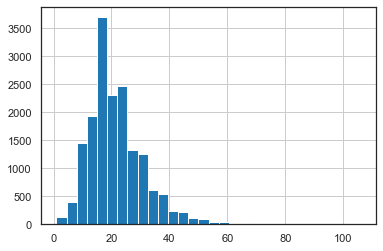

In [211]:
rec.days_between_pos_and_neg.hist(bins=30)

In [212]:
iso = pd.read_csv(get_latest_file_glob('data/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad
0,2020-07-01,27660,7415,4295,643
1,2020-06-30,25815,7431,4885,533
2,2020-06-29,23469,7486,3492,666
3,2020-06-28,22264,7587,3859,534
4,2020-06-27,19551,7463,1731,338


In [213]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [214]:
niv.age_60_and_above.value_counts()

No     253209
Yes     44362
Name: age_60_and_above, dtype: int64

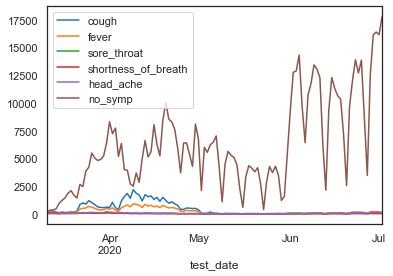

In [215]:
niv.groupby('test_date')[symptom_cols].sum().plot()

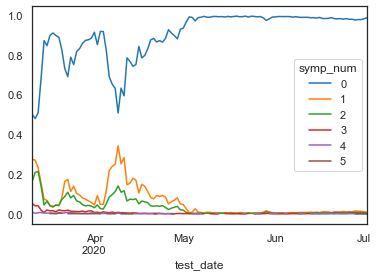

In [216]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

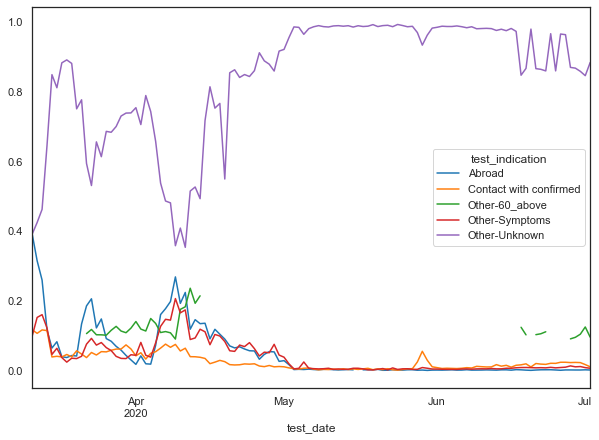

In [217]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

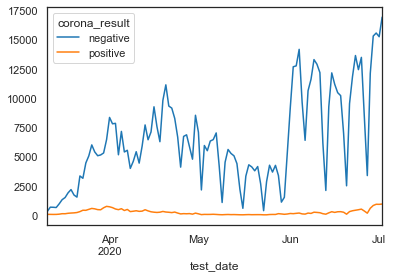

In [218]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [219]:
bdi.dtypes

test_date         datetime64[ns]
result_date       datetime64[ns]
corona_result             object
lab_id                     int64
is_first_Test             object
orig_test_date    datetime64[ns]
dtype: object

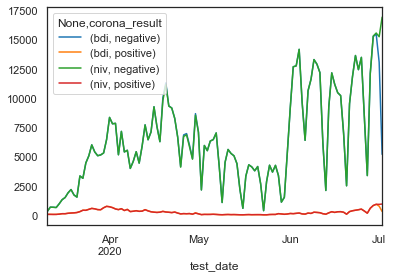

In [220]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

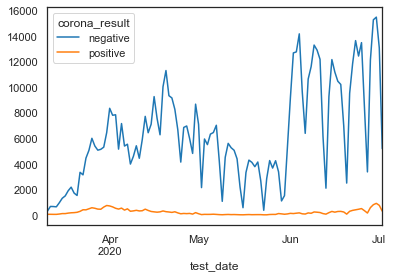

In [221]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [222]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='No')].groupby(['test_date', 'corona_result']).size().unstack()

corona_result,negative,positive
test_date,,
2020-03-11,2,3
2020-03-12,21,7
2020-03-13,21,2
2020-03-14,24,1
2020-03-15,70,47
...,...,...
2020-06-28,5243,287
2020-06-29,7183,337
2020-06-30,5448,336


In [223]:
pone = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'corona_result']).size().unstack()
pone[pone.positive<20]

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-05-08,28.0,NaN,4199.0,18.0,NaN
2020-05-09,31.0,NaN,1057.0,9.0,NaN
2020-05-12,46.0,NaN,5250.0,19.0,NaN
2020-05-14,57.0,1.0,4379.0,16.0,NaN
2020-05-15,28.0,NaN,2183.0,7.0,NaN
2020-05-16,25.0,NaN,559.0,4.0,NaN
2020-05-17,58.0,NaN,3313.0,15.0,NaN
2020-05-19,32.0,NaN,4104.0,12.0,NaN
2020-05-20,42.0,NaN,3768.0,16.0,NaN


In [224]:
pone.tail(5)

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-06-28,182.0,NaN,12103.0,566.0,NaN
2020-06-29,406.0,1.0,15254.0,795.0,NaN
2020-06-30,250.0,NaN,15462.0,899.0,NaN
2020-07-01,136.0,1.0,13054.0,743.0,NaN
2020-07-02,75.0,NaN,5175.0,287.0,NaN


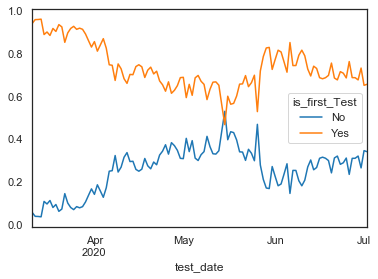

In [225]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

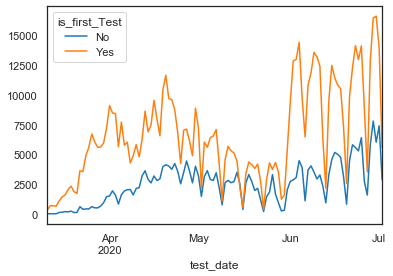

In [226]:
ti.plot()

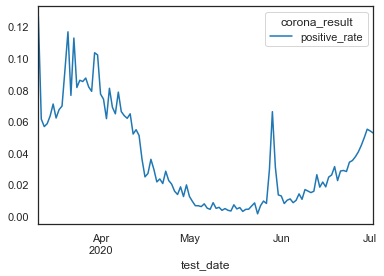

In [227]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']]
 .plot())

In [228]:
import altair as alt
ti.tail()

is_first_Test,No,Yes
test_date,,
2020-06-28,5811,12851
2020-06-29,7806,16456
2020-06-30,6029,16611
2020-07-01,7407,13934
2020-07-02,2881,5537


In [229]:
ti.Yes.sum() + ti.No.sum()

1043340

In [230]:
alt.Chart(ti.reset_index().assign(total=lambda x: x.Yes+x.No)).mark_line().encode(
    x='test_date',
    y='Yes',
    tooltip=['test_date', 'Yes']
).interactive()

alt.Chart(...)

In [231]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [232]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [233]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'מונשמים': 'resp'}

In [241]:
hos = (pd.read_csv(get_latest_file_glob('data/corona_hospitalization_ver_*.csv.gz'), encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

,date,מאושפזים,אחוז נשים מאושפזות,גיל ממוצע מאושפזים,סטיית תקן גיל מאושפזים,resp,אחוז נשים מונשמות,גיל ממוצע מונשמים,סטיית תקן גיל מונשמים,חולים קל,...,גיל ממוצע חולים קל,סטיית תקן גיל חולים קל,חולים בינוני,אחוז נשים חולות בינוני,גיל ממוצע חולים בינוני,סטיית תקן גיל חולים בינוני,critical,אחוז נשים חולות קשה,גיל ממוצע חולים קשה,סטיית תקן גיל חולים קשה
0,2020-03-11,78,35.9,48.0,18.1,15,33.3,68.0,18.2,70,...,46.0,16.9,NaN,NaN,NaN,NaN,15,42.9,71.0,17.7
1,2020-03-12,100,39.0,50.0,18.5,15,33.3,68.0,18.2,92,...,48.0,17.8,NaN,NaN,NaN,NaN,15,42.9,71.0,17.7
2,2020-03-13,120,39.2,49.0,18.4,15,33.3,68.0,18.2,109,...,47.0,17.4,<15,50.0,64.0,17.3,15,42.9,71.0,17.7
3,2020-03-14,158,41.1,47.0,18.5,15,25.0,76.0,12.8,148,...,45.0,17.4,<15,50.0,64.0,17.3,15,33.3,79.0,11.4
4,2020-03-15,198,44.9,46.0,18.8,15,33.3,77.0,10.3,183,...,44.0,17.5,<15,50.0,58.0,14.9,15,44.4,80.0,9.7


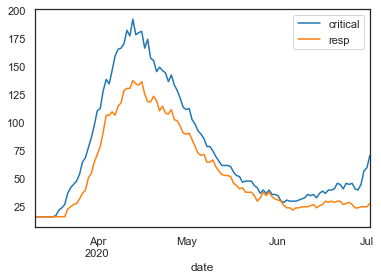

In [242]:
(hos[['date', 'critical', 'resp']].set_index('date').plot())

In [243]:
hos_and_rate = hos[['date', 'critical', 'resp']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


,test_date,critical,resp,negative,positive,positive_rate
0,2020-03-11,15,15,297,43,0.126471
1,2020-03-12,15,15,658,43,0.061341
2,2020-03-13,15,15,650,39,0.056604
3,2020-03-14,15,15,628,39,0.058471
4,2020-03-15,15,15,946,64,0.063366


In [244]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [245]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').encode()


alt.LayerChart(...)

No handles with labels found to put in legend.


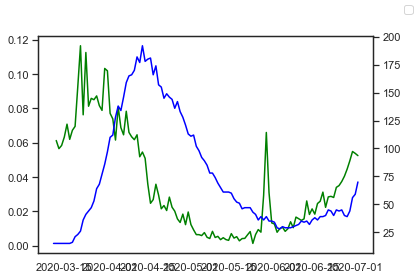

In [246]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()
